In [8]:
# Load various imports
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [9]:
mypath = "data/downsampled_clips"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))]

In [10]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file)

In [11]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [12]:
p_diag = pd.read_csv("data/Respiratory_Sound_Database/patient_diagnosis.csv",header=None) # patient diagnosis file

In [13]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files


In [14]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    return data

In [15]:
def stretch_process(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

In [16]:
def pitch_process(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [17]:
def extract_process(data, sample_rate):
    output_result = np.array([])

    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    output_result = np.hstack((output_result, mean_zero))

    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, chroma_stft))

    mfcc_out = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    output_result = np.hstack((output_result, mfcc_out))

    root_mean_out = np.mean(librosa.feature.rms(y=data).T, axis=0)
    output_result = np.hstack((output_result, root_mean_out))

    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, mel_spectogram))

    return output_result

In [18]:
def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it,
    and extracts several audio features including mean values of MFCC, Zero Crossing Rate,
    Chromagram, Root Mean Square Energy, and Mel Spectrogram from the original and its augmented versions.
    """
    try:
        # Load the original audio file
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=42, offset=0.6)

        # Extract features from the original audio data
        extracted_features = extract_process(audio, sample_rate)
        result = np.array(extracted_features)

        # Add noise and extract features
        noise_out = add_noise(audio)
        output_2 = extract_process(noise_out, sample_rate)
        result = np.vstack((result, output_2))

        # Time-stretch and then pitch-shift before extracting features
        new_out = stretch_process(audio,0.8)
        stretch_pitch = pitch_process(new_out, sample_rate,pitch_factor=0.7)
        output_3 = extract_process(stretch_pitch, sample_rate)
        result = np.vstack((result, output_3))

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print("Error Details:", e)
        return None

    return result

In [19]:
features = []

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)

/Users/akshayraj/Documents/GT/s4/7641/RespiratorySoundProject/env/lib/python3.12/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Finished feature extraction from  920  files


In [20]:
features.shape

(920, 3, 182)

In [21]:
# print class counts
unique_elements, counts_elements = np.unique(labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Asthma' 'Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'LRTI'
  'Pneumonia' 'URTI']
 ['1' '16' '13' '793' '35' '2' '37' '23']]


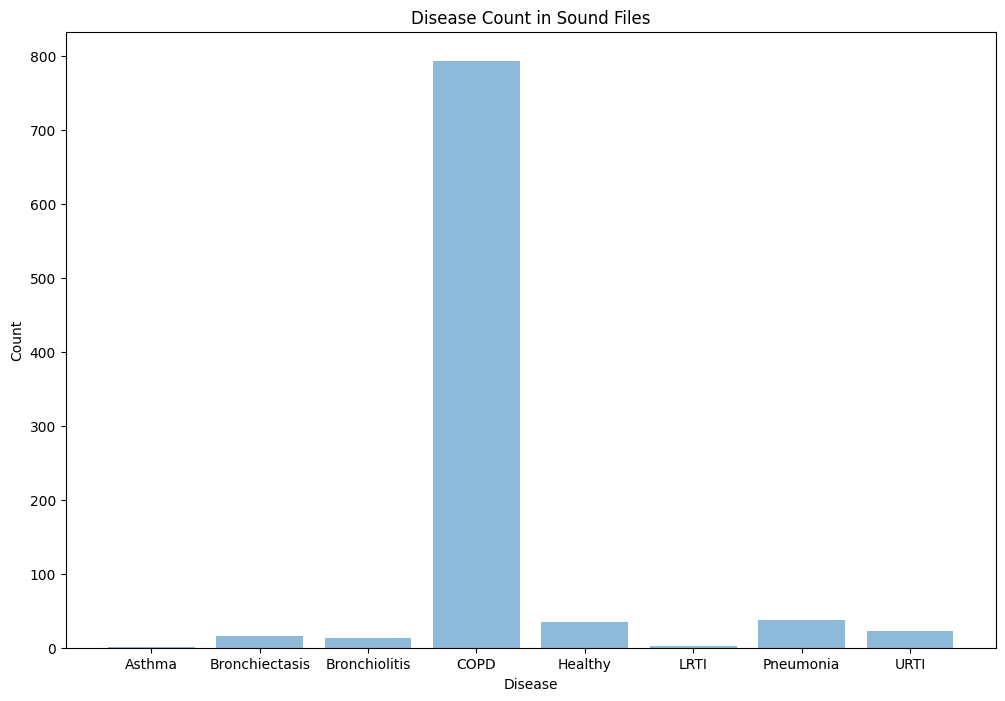

In [22]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files')
plt.show()

In [148]:
flattened_features = features.reshape(-1, 182)

In [149]:
augmented_labels = np.repeat(labels, 3)

In [150]:
augmented_features = np.reshape(features, (-1, 182))  # Flatten the feature sets
augmented_features.shape
mask = ~np.isin(augmented_labels, [])
augmented_features = augmented_features[mask]
augmented_labels = augmented_labels[mask]

In [151]:
le = LabelEncoder()
i_labels = le.fit_transform(augmented_labels)
oh_labels = to_categorical(i_labels)

In [152]:
oh_labels.shape

(2760, 8)

In [153]:
flattened_features.shape

(2760, 182)

In [154]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(flattened_features, oh_labels, stratify=oh_labels,
                                                    test_size=0.2, random_state = 42)

In [155]:
#SCALER & TRANSFORMATION
scaler_data = StandardScaler()

In [156]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2208, 182)
(2208, 8)
(552, 182)
(552, 8)


In [157]:
x_train = scaler_data.fit_transform(x_train)
x_test = scaler_data.transform(x_test)

In [5]:
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)

NameError: name 'np' is not defined

In [159]:
from tensorflow.keras import layers, Sequential, regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization, Add, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Model, Input

def res_block(filter, stage):
    def layer_fn(X):
        X_copy = X

        X = layers.Conv1D(filters = filter, kernel_size = 5, strides = 1, padding = 'same', name = 'conv1' + str(stage))(X)
        X = BatchNormalization(name = 'bn1' + str(stage))(X)
        X = Activation('relu')(X)

        # Add skip connection
        X_copy = layers.Conv1D(filters = filter, kernel_size = 1, strides = 1, padding = 'same', name = 'skip' + str(stage))(X_copy)
        X = Add()([X, X_copy])
        X = Activation('relu')(X)

        return X
    return layer_fn

# Define the model
inputs = Input(shape=(x_train.shape[1], 1))

# Initial layer
x = layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same')(x)

# Add residual blocks
for i in range(3):
    x = res_block(256, i+1)(x)
x = layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same')(x)

# Final layers
x = layers.Dropout(0.4)(x)
x = layers.Flatten()(x)
x = layers.Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.02))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(units=num_labels, activation='softmax')(x)

Model = Model(inputs=inputs, outputs=outputs)

opt = optimizers.Adam(learning_rate=0.001)

# Compile the model
Model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5)

# Fit the model
evConv1D_Model = Model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_reduction])

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.7742 - loss: 2.7919 - val_accuracy: 0.8623 - val_loss: 1.6400 - learning_rate: 0.0010
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8414 - loss: 1.3221 - val_accuracy: 0.8623 - val_loss: 1.0730 - learning_rate: 0.0010
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.8537 - loss: 0.9420 - val_accuracy: 0.8623 - val_loss: 0.8917 - learning_rate: 0.0010
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8555 - loss: 0.7955 - val_accuracy: 0.8605 - val_loss: 0.7828 - learning_rate: 0.0010
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.8516 - loss: 0.7440 - val_accuracy: 0.8623 - val_loss: 0.7135 - learning_rate: 0.0010
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.8607 - loss: 0.6629 - val_accuracy: 0.8623 - val_loss: 0.6408 - learning_rate: 0.0010
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.8728 - loss: 0.6176 - 

In [162]:
Model_Results = Model.evaluate(x_train,y_train)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])
Model_Results = Model.evaluate(x_test,y_test)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9913 - loss: 0.1102
LOSS:  0.1042
ACCURACY:  0.9937
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9073 - loss: 0.4816
LOSS:  0.4425
ACCURACY:  0.9185


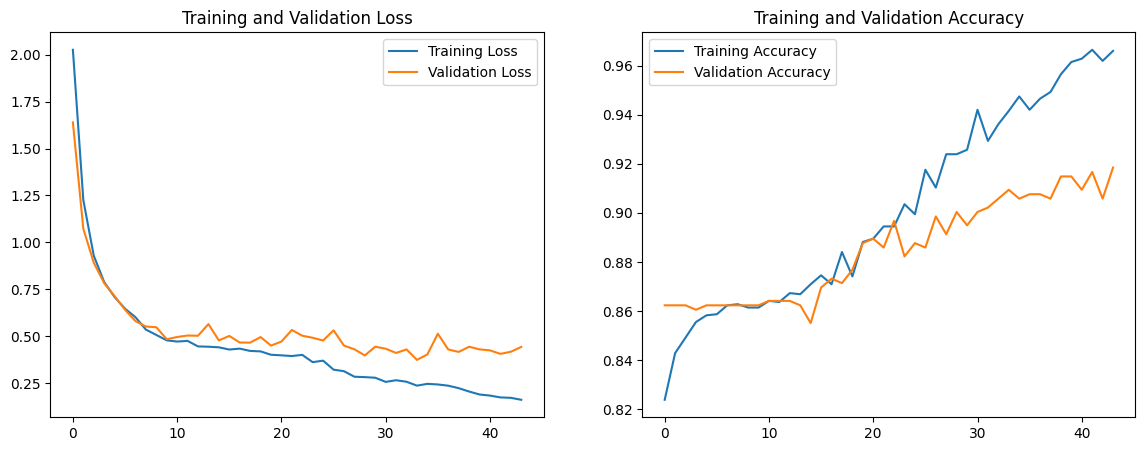

In [163]:
# Plotting loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(evConv1D_Model.history['loss'], label='Training Loss')
plt.plot(evConv1D_Model.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(evConv1D_Model.history['accuracy'], label='Training Accuracy')
plt.plot(evConv1D_Model.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


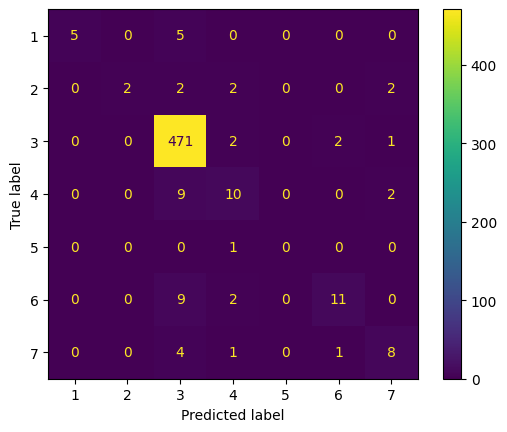

In [164]:
# Getting the predictions
y_pred = Model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generating the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

le.fit(np.union1d(y_true, y_pred_classes))
assert confusion_mtx.shape[0] == confusion_mtx.shape[1] == len(le.classes_)

# Displaying the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_mtx, display_labels=le.classes_).plot()

In [165]:
from tensorflow.keras import layers, Sequential

num_labels = len(np.unique(labels)) 

Model2 = Sequential([
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units=32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=num_labels, activation='softmax')
])
Model2.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
evConv1D_Model2 = Model2.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/100


/Users/akshayraj/Documents/GT/s4/7641/RespiratorySoundProject/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.7441 - loss: 1.1259 - val_accuracy: 0.8623 - val_loss: 0.6064
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8592 - loss: 0.7249 - val_accuracy: 0.8623 - val_loss: 0.6029
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8632 - loss: 0.6849 - val_accuracy: 0.8623 - val_loss: 0.5804
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8708 - loss: 0.6094 - val_accuracy: 0.8623 - val_loss: 0.5693
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8675 - loss: 0.5851 - val_accuracy: 0.8623 - val_loss: 0.5395
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8588 - loss: 0.5487 - val_accuracy: 0.8623 - val_loss: 0.5621
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.8657 - loss: 0.5149 - val_accuracy: 0.8623 - val_loss: 0.5144
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8611 - loss: 0.5202 - val_accuracy: 0.8623 - val_l

In [166]:
Model_Results = Model2.evaluate(x_train,y_train)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])
Model_Results = Model2.evaluate(x_test,y_test)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9583 - loss: 0.1364
LOSS:  0.1319
ACCURACY:  0.9574
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8877 - loss: 0.5592
LOSS:  0.5254
ACCURACY:  0.8895


Plotting Train and Validation Loss & Accuracy:

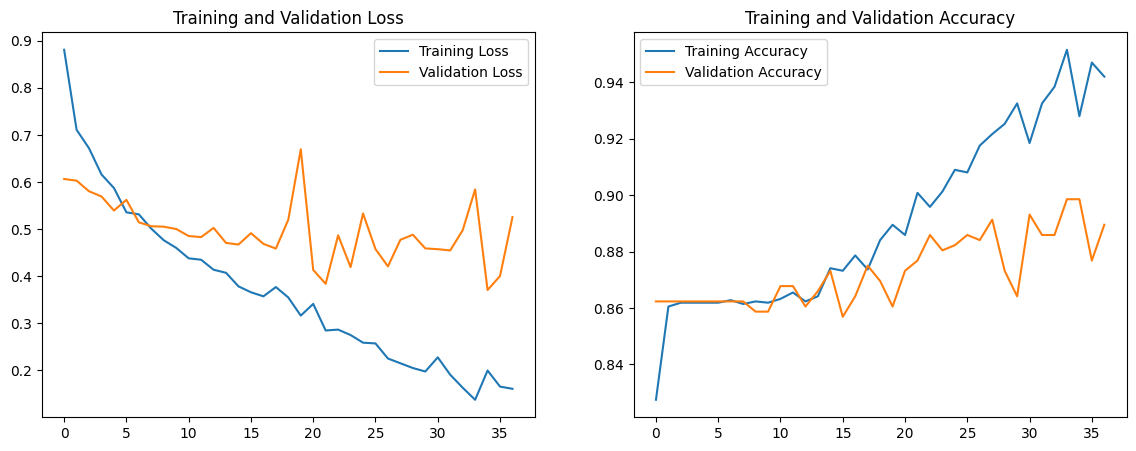

In [167]:
# Plotting loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(evConv1D_Model2.history['loss'], label='Training Loss')
plt.plot(evConv1D_Model2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(evConv1D_Model2.history['accuracy'], label='Training Accuracy')
plt.plot(evConv1D_Model2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


Confusion Matrix:

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


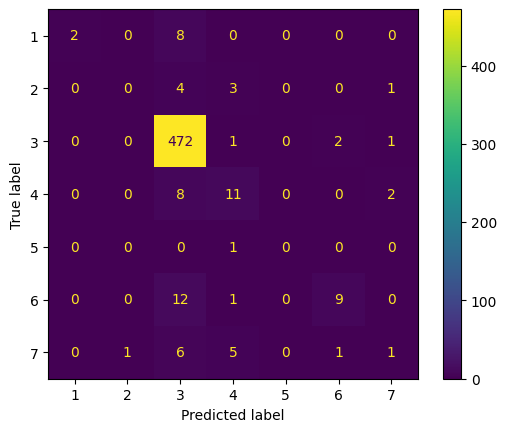

In [74]:
# Getting the predictions
y_pred = Model2.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generating the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

le.fit(np.union1d(y_true, y_pred_classes))
assert confusion_mtx.shape[0] == confusion_mtx.shape[1] == len(le.classes_)

# Displaying the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_mtx, display_labels=le.classes_).plot()